In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator

# Chebyshev polynomial code

In [2]:
def evaluate_ith_chebyshev_polynomial(xs, i):
    """Evaluates the ith Chebyshev polynomial at imputs xs."""
    tprev = np.ones_like(xs)
    tnext = xs.copy()
    if i == 0:
        return tprev
    elif i == 1:
        return tnext
    else:
        k = 1
        while k < i:
            tnew = 2*xs*tnext - tprev
            tprev = tnext
            tnext = tnew
            k += 1
        return tnew

In [8]:
evaluate_ith_chebyshev_polynomial(np.lin, 3)

array([1., 1., 1., 1., 1.])

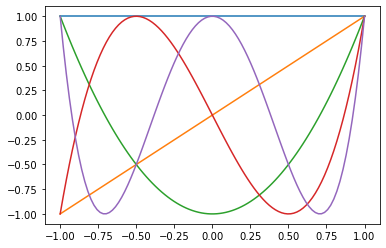

In [9]:
dom = np.linspace(-1, 1, 100)
for j in range(5):
    rang = evaluate_ith_chebyshev_polynomial(dom, j)
    plt.plot(dom, rang)
plt.show()

In [3]:
def get_chebyshev_coeff(f, n, i):
    """Computes the ith Chebyshev coefficient in the expansion
            f(x) \approx \sum_{j=0}^n c_j T_j(x).
    Here f:[-1,1] \to \mathbb{R}. 
    """

    # Get nodes
    ks = np.arange(n+1)
    xks = np.cos(  np.pi*( ks + 0.5 )/(n+1)  )

    if i == 0:
        chebyshev_coeff = (1/(n+1))*(f(xks)*1).sum()
    else:
        chebyshev_coeff = (2/(n+1))*(f(xks)*evaluate_ith_chebyshev_polynomial(xks, i) ).sum()
        

    return chebyshev_coeff


In [27]:
dom = np.linspace(-1, 1, 100)
f = lambda x: np.log(1-x)
#f = lambda x: x**2
n = 30

f_approx = np.zeros_like(dom)
for j in range(n+1):
    f_approx += get_chebyshev_coeff(f, n, j)*evaluate_ith_chebyshev_polynomial(dom, j)

/var/folders/8y/4mq6cs_x20j1gp06wytwhlwm0000gn/T/ipykernel_10952/3197065710.py:2: RuntimeWarning: divide by zero encountered in log
  f = lambda x: np.log(1-x)


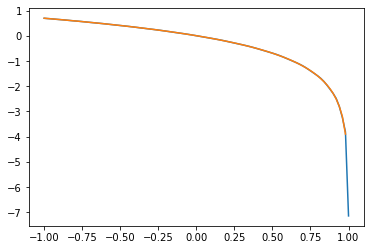

In [28]:
plt.plot(dom, f_approx)
plt.plot(dom, f(dom))
plt.show()

# Estimating log determinants for positive definite matrices with $\sigma_{\text{max}} < 1$.

In [341]:
def logdet_approx_bounded_by_one(B, sample_size=100, chebyshev_n=14, chebyshev_delta=0.05):
    """Computes an approximation to logdet(B) for a positive definite matrix A with \sigma_{\text{max}} < 1.
    Assumes B is provided as a LinearOperator.

    TO-DO: Can't seem to get chebyshev_delta to behave well with the stated formula?
    """

    # Get dimension
    d = B.shape[0]

    # Make identity operator
    id_op = LinearOperator(shape=(d,d), matvec=lambda x: x, rmatvec=lambda x: x)

    # Make A and estimate
    A = id_op - B
    logdet_estimate = 0.0

    # Compute chebyshev coefficients
    #f = lambda x: np.log(1 - x)
    f = lambda x: np.log( 1.0 - ( ((1.0 - (2*chebyshev_delta))*x)/2  ) + 0.5 )
    ginv = lambda x: (2/(1 - 2*chebyshev_delta))*x

    chebyshev_coeffs = [ get_chebyshev_coeff(f, chebyshev_n, i) for i in range(0, chebyshev_n+1) ]

    # Random sampling
    for j in range(sample_size):
        
        # Draw random vector
        v = np.random.choice([-1, 1], size=d)
        u = chebyshev_coeffs[0]*v

        if chebyshev_n > 1:
            w0 = v
            Av = A @ v
            w1 = Av
            
            u += chebyshev_coeffs[1]*Av
            for k in range(2, chebyshev_n+1):
                w2 = (2*(A @ w1)) - w0
                u += chebyshev_coeffs[k]*w2
                w0 = w1
                w1 = w2
        
        logdet_estimate += (np.dot(v, u))/sample_size

    return logdet_estimate

In [305]:

def logdet_via_cholesky(A, banded_cholesky=False):
    """Computes logdet(A) using the Cholesky method. A must be SPD."""

    if not banded_cholesky:
        chol = np.linalg.cholesky(A)
    else:
        raise NotImplementedError

    return 2*np.sum(np.log(np.diag(chol)))

In [306]:
# Generate random SPD matrix with sigma_max < 1?
from scipy.stats import ortho_group
from scipy.sparse.linalg import aslinearoperator

In [307]:
d = 10
basis = ortho_group.rvs(d)
eigvals = np.random.uniform(low=0.2, high=0.80, size=d)
B = basis @ np.diag(eigvals) @ basis.T
true_logdet = logdet_via_cholesky(B)

xi = 0.1
eps = 0.1
samples = int(  np.ceil( 54*(1/(eps**2))*np.log(2/xi) ) )
print(samples)

logdet_est = logdet_approx_bounded_by_one(aslinearoperator(B), sample_size=samples, chebyshev_n=14, chebyshev_delta=0.1)

16177


In [308]:
print(np.log(np.linalg.det(B)))
print(true_logdet)
print(logdet_est)

-7.460544205193627
-7.460544205193627
-7.510642139524098


In [309]:
d = 10
basis = ortho_group.rvs(d)
eigvals = np.random.uniform(low=0.2, high=10.0, size=d)
B = basis @ np.diag(eigvals) @ basis.T
true_logdet = logdet_via_cholesky(B)

xi = 0.1
eps = 0.1
samples = int(  np.ceil( 54*(1/(eps**2))*np.log(2/xi) ) )
print(samples)

logdet_est = logdet_approx_bounded_by_one(aslinearoperator(B), sample_size=samples, chebyshev_n=14, chebyshev_delta=0.1)

16177


In [310]:
print(np.log(np.linalg.det(B)))
print(true_logdet)
print(logdet_est)

14.913255875624554
14.913255875624554
-3182072711330899.5


# Next, for general SPD matrices?

In [311]:
from scipy.sparse.linalg import eigs as scipy_eigs

In [352]:
def logdet_approx(C, sample_size=100, chebyshev_n=14, chebyshev_delta=0.05):
    """Computes an approximation to logdet(C) for a positive definite matrix A.
    Assumes C is provided as a LinearOperator.

    TO-DO: Can't seem to get chebyshev_delta to behave well with the stated formula?
    """

    # Get dimension
    d = C.shape[0]

    # Get largest and smallest singular values
    sigma_max, _ = scipy_eigs(C, k=1, which="LM")
    sigma_min, _ = scipy_eigs(C, k=1, which="SM")
    sigma_max, sigma_min = np.real(sigma_max[0]), np.real(sigma_min[0])
    
    # Make B and delta
    B = (1.0/(sigma_min**2 + sigma_max**2))*(C.T @ C)
    delta = (sigma_min**2)/(sigma_min**2 + sigma_max**2)

    # Call bounded logdet
    logdet_est = logdet_approx_bounded_by_one(B, sample_size=sample_size, chebyshev_n=chebyshev_n, chebyshev_delta=delta)
    logdet_est = (logdet_est + d*np.log(sigma_min**2 + sigma_max**2))/2.0

    return logdet_est

In [353]:
d = 10
basis = ortho_group.rvs(d)
eigvals = np.random.uniform(low=0.2, high=10.0, size=d)
B = basis @ np.diag(eigvals) @ basis.T
true_logdet = logdet_via_cholesky(B)

In [354]:
samples = 100
logdet_est = logdet_approx(aslinearoperator(B), sample_size=samples, chebyshev_n=15, chebyshev_delta=0.1)

In [355]:
print(np.log(np.linalg.det(B)))
print(true_logdet)
print(logdet_est)

15.072239457221698
15.072239457221698
23.319677187469974


# From author code?

In [ ]:
function ld = ChebLogDet( C, M, n, lmin, lmax )
% C : SPSD matrix with eigenvalues in [lmin , lmax]
% M : number of sampling for trace estimator
% n : Chebyshev approximate degree

if nargin == 4
    a = 1;
    delta = lmin;    
elseif nargin == 5
    a = lmin + lmax;
    delta = lmin / a;
end

% normalize B with eigenvalues in [delta, 1-delta]
B = C./a;

f = @(x) log(1-x);
g = @(x) ((1-2*delta)/2).*x+0.5;
ginv = @(x) (2/(1-2*delta)).*x;
h = @(x) f(g(x));

c = chebpolfit(h,n);

v = sign(randn(size(B,1),M));

u = c(1)*v;
if n>0
    w0 = v;
    w1 = (B*v);
    w1 = ginv(w1);
    w1 = v./(1-2*delta)-w1;
    u = c(2)*w1 + c(1)*w0;

    for j = 3 : n+1
        ww = (B*w1);
        ww = ginv(ww);
        ww = w1./(1-2*delta)-ww;
        ww = 2*(ww) - w0;
        u = c(j)*ww + u;
        w0 = w1;
        w1 = ww;
    end
end
ld = sum(sum(v.*u))/M + size(C,1) * log(a);
end

function c = chebpolfit(fname,n)
x = cos(((0:n)'+0.5)*pi/(n+1));
y = feval(fname,x);
T = [zeros(n+1,1) ones(n+1,1)];
c = [sum(y)/(n+1) zeros(1,n)];
a = 1;
for k = 2 : n+1
    T = [T(:,2) a*x.*T(:,2)-T(:,1)];
    c(k) = (y'*T(:,2))*2/(n+1);
    a = 2;
end
end

In [ ]:
function ld = ChebLogDet( C, M, n, lmin, lmax )
% C : SPSD matrix with eigenvalues in [lmin , lmax]
% M : number of sampling for trace estimator
% n : Chebyshev approximate degree

if nargin == 4
    a = 1;
    delta = lmin;    
elseif nargin == 5
    a = lmin + lmax;
    delta = lmin / a;
end

% normalize B with eigenvalues in [delta, 1-delta]
B = C./a;

In [374]:
def logdet_stochastic_chebyshev_approx(C, sigma_max, sigma_min, sample_size=100, chebyshev_n=14):
    """Computes an approximation to logdet(C) for a SPSD matrix C, using the 
    stochastic Chebyshev approximation detailed in [7]. Eigenvalues of C are assumed to lie in
    the interval [sigma_min, sigma_max].

    Modified from author code here: https://alinlab.kaist.ac.kr/publications.html.
    """

    # Get dimension
    d = C.shape[0]

    # Get largest and smallest singular values
    sigma_max, _ = scipy_eigs(C, k=1, which="LM")
    sigma_min, _ = scipy_eigs(C, k=1, which="SM")
    sigma_max, sigma_min = np.real(sigma_max[0]), np.real(sigma_min[0])

    # Scaling
    a = sigma_min + sigma_max
    delta = sigma_min/a

    # Make B
    B = (1/a)*C
    logdet_estimate = 0.0

    # Funcs
    f = lambda x: np.log(1-x)
    g = lambda x: ((1-2*delta)/2)*x + 0.5
    ginv = lambda x: (2/(1-2*delta))*x
    h = lambda x: f(g(x))

    # Get Chebyshev coeffs
    chebyshev_coeffs = [ get_chebyshev_coeff(h, chebyshev_n, i) for i in range(0, chebyshev_n+1) ]

    # Random sampling
    for j in range(sample_size):
        
        # Draw random vector
        v = np.random.choice([-1, 1], size=d)
        u = chebyshev_coeffs[0]*v

        if chebyshev_n > 1:
            w0 = v
            w1 = B @ v
            w1 = ginv(w1)
            w1 = v/(1 - 2*delta) - w1
            u = chebyshev_coeffs[1]*w1 + chebyshev_coeffs[0]*w0

            for k in range(2, chebyshev_n+1):

                w2 = B @ w1
                w2 = ginv(w2)
                w2 = w1/(1 - 2*delta) - w2
                w2 = 2*w2 - w0
                u = chebyshev_coeffs[k]*w2 + u
                w0 = w1
                w1 = w2
        
        logdet_estimate += (np.dot(v, u))/sample_size

    logdet_estimate += d*np.log(a)

    return logdet_estimate

In [378]:
def logdet_stochastic_chebyshev_epsilon_delta_approx(C, epsilon=0.1, zeta=0.1, sample_size=None):
    """Computes an approximation to logdet(C) for a SPD matrix C, using the 
    stochastic Chebyshev approximation detailed in [7]. Returns an estimate
    \hat{logdet}(C) s.t. |logdet(C) - \hat{logdet}(C)| < epsilon*|logdet(C)| 
    with at least probaility 1-zeta. 

    If you override sample_size (which you might do since the bound is loose), you
    no longer have the same guarantee.

    Modified from author code here: https://alinlab.kaist.ac.kr/publications.html.
    """

    # Get largest and smallest singular values
    sigma_max, _ = scipy_eigs(C, k=1, which="LM")
    sigma_min, _ = scipy_eigs(C, k=1, which="SM")
    sigma_max, sigma_min = np.real(sigma_max[0]), np.real(sigma_min[0])
    kappa = sigma_max/sigma_min

    # Compute M and N
    M = (14/(epsilon**2))*((np.log(1 + (kappa**2)))**2)*np.log(2/zeta) # lower bound on sample size
    N_denom = np.log( ( np.sqrt(2*(kappa**2) + 1) + 1  ) / ( np.sqrt(2*(kappa**2) + 1) - 1 )  )
    N_num = np.log( (20/epsilon)*( np.sqrt( 2*(kappa**2) + 1 ) - 1 )*( (np.log(2 + 2*(kappa**2))) / (np.log(1 + (1/(kappa**2))))  )  )
    N = N_num/N_denom # chebyshev_n

    M = int(np.ceil(M))
    N = int(np.ceil(N))

    print(M)
    print(N)

    return logdet_stochastic_chebyshev_approx(C, sigma_max, sigma_min, sample_size=M, chebyshev_n=N)

In [382]:
d = 10
basis = ortho_group.rvs(d)
eigvals = np.random.uniform(low=9.0, high=10.0, size=d)
B = basis @ np.diag(eigvals) @ basis.T
true_logdet = logdet_via_cholesky(B)

In [383]:
samples = 100
logdet_est = logdet_stochastic_chebyshev_epsilon_delta_approx(B, epsilon=0.1, zeta=0.1)

2635
5


In [384]:
print(np.log(np.linalg.det(B)))
print(true_logdet)
print(logdet_est)

22.318421929617287
22.31842192961729
22.317459109559543
